In [1]:
!pip install pyspark

In [1]:
# extrair os dados zipados e adicionando em uma pasta chamada dimensional_dataset
!unzip dimensional_dataset.zip -d dimensional_dataset

Archive:  dimensional_dataset.zip
   creating: dimensional_dataset/content/dimensional_dataset/
  inflating: dimensional_dataset/content/dimensional_dataset/.part-00001-ba5921f9-3b0d-4009-b226-33c4efebcca3-c000.snappy.parquet.crc  
 extracting: dimensional_dataset/content/dimensional_dataset/_SUCCESS  
  inflating: dimensional_dataset/content/dimensional_dataset/part-00001-ba5921f9-3b0d-4009-b226-33c4efebcca3-c000.snappy.parquet  
  inflating: dimensional_dataset/content/dimensional_dataset/part-00000-ba5921f9-3b0d-4009-b226-33c4efebcca3-c000.snappy.parquet  
 extracting: dimensional_dataset/content/dimensional_dataset/._SUCCESS.crc  
  inflating: dimensional_dataset/content/dimensional_dataset/.part-00000-ba5921f9-3b0d-4009-b226-33c4efebcca3-c000.snappy.parquet.crc  


In [2]:
from pyspark.sql import SparkSession
#criando a nova sessão
spark = SparkSession.builder.appName("dimensional").getOrCreate()

In [3]:
# lendo o arquivo
df = spark.read.parquet('dimensional_dataset/content/dimensional_dataset')
df.show(5)

+--------------------+----------+-----------------+--------------------+--------------------+--------------------+--------------------+--------------------+------------------+--------+
|             address|birth_date|        city_name|        country_name|               email|                 job|           person_id|         person_name|      phone_number|zip_code|
+--------------------+----------+-----------------+--------------------+--------------------+--------------------+--------------------+--------------------+------------------+--------+
|25120 Williams Vi...|1955-04-04|      Hughesmouth|             Ukraine|veronicasmith@exa...|Holiday represent...|91997245-126b-41b...|        Ashley Allen|      701.806.3784|   84095|
|832 Hamilton Stra...|1979-01-15|       Debbieside|        South Africa|jasoncuevas@examp...|Television camera...|e58eb4e8-7d53-4bf...|Mrs. Christine Wi...|  279-975-4319x478|   26828|
|5872 Hines Point\...|1972-04-18|Lake Kathleenfort|             Albania|ben

In [4]:
df.count()

1000000

### DataFrame de People

In [5]:
# Criar o DF de pessoas, percorrer people_cols e as colunas e salvar apenas as pessoas sem repetir (distinct)
people_cols = ['person_id', 'person_name', 'birth_date', 'email', 'phone_number', 'job']
people_df = df.select(*people_cols).distinct()
people_df.show(5)

+--------------------+----------------+----------+--------------------+------------------+--------------------+
|           person_id|     person_name|birth_date|               email|      phone_number|                 job|
+--------------------+----------------+----------+--------------------+------------------+--------------------+
|b51b4223-dd02-465...|   Daniel Murphy|1959-03-28|  wjones@example.com|      534.881.7660|Sales promotion a...|
|dfb967b7-4bb9-421...|   Nicole Miller|1982-02-06| sarah56@example.com|291.490.3041x24946|Pharmacist, hospital|
|21dcad28-d714-49d...|     Donald Clay|1957-01-01|ronaldcollins@exa...|      605.326.9060|Building control ...|
|09d667e6-fcd0-4b3...|    Erin Jackson|1952-03-23|williamssummer@ex...|  001-708-671-0792|Brewing technologist|
|79a3bcb6-c1a0-46e...|Frederick Hebert|2001-01-05|  xallen@example.net|884.329.2125x96089|Conservation offi...|
+--------------------+----------------+----------+--------------------+------------------+--------------

### DataFrame de Cidades

In [6]:
# Importar funções e apelidar de F
from pyspark.sql import functions as F

In [7]:
# Passa nas colunas informadas e salva do df_city, a função col , alias está pegando a coluna e renomeando
cities_cols = ['city_name', 'zip_code', F.col('country_name').alias('country')]
cities_df = df.select(*cities_cols).distinct()
cities_df.show(5)

+-------------------+--------+--------------------+
|          city_name|zip_code|             country|
+-------------------+--------+--------------------+
|        Heatherfurt|   22382|            Maldives|
|East Elizabethhaven|   66630|Libyan Arab Jamah...|
|        Johnsonberg|   99248|            Colombia|
|        Gloriaville|   08543|French Southern T...|
|       New Kristina|   58862|             Jamaica|
+-------------------+--------+--------------------+
only showing top 5 rows



### DataFrame de Países

In [8]:
# função de select do SQL
countries_df = df.selectExpr('country_name as coutry').distinct()
countries_df.show(5)

+--------------------+
|              coutry|
+--------------------+
|                Chad|
|            Anguilla|
|            Paraguay|
|               Macao|
|Heard Island and ...|
+--------------------+
only showing top 5 rows



### DataFrame de Endereços

In [9]:
addresses_cols = ['address', 'zip_code', 'city_name', 'country_name']
addresses_df = df.select(*addresses_cols).distinct()
addresses_df.show(5)

+--------------------+--------+-------------+-----------------+
|             address|zip_code|    city_name|     country_name|
+--------------------+--------+-------------+-----------------+
|90399 Larsen Port...|   71342|  North Sally| Papua New Guinea|
|643 Michelle Cent...|   72378|   Stokestown|            Egypt|
|93097 Holmes Bypa...|   69602|   Josephland|          Croatia|
|5456 Henderson Sh...|   33686|   Jimmyshire|           Jordan|
|929 Griffith Shor...|   10464|Alexanderside|Wallis and Futuna|
+--------------------+--------+-------------+-----------------+
only showing top 5 rows



### DataFrame de Empregos

In [10]:
jobs_df = df.select('job').groupBy('job').count()
jobs_df.show(10)

+--------------------+-----+
|                 job|count|
+--------------------+-----+
|    Catering manager| 1609|
|Diplomatic Servic...| 1568|
|Designer, ceramic...| 1562|
| Retail merchandiser| 1530|
| Librarian, academic| 1539|
|Engineer, aeronau...| 1516|
|Occupational hygi...| 1519|
|English as a seco...| 1628|
|Primary school te...| 1535|
| Early years teacher| 1504|
+--------------------+-----+
only showing top 10 rows



### DataFrame de Faixa Etária

In [11]:
age_df = df.select('person_id', 'birth_date',
          F.when(F.year(F.current_date()) - F.year(F.col('birth_date')) < 20, 'Under 20') # Se maior que 20
          .when(F.year(F.current_date()) - F.year(F.col('birth_date')) < 40, '20-39')   # Se maior que 40
          .when(F.year(F.current_date()) - F.year(F.col('birth_date')) < 60, '40-59')   # Se maior que 60
          .otherwise('60+').alias('age_group'))                                         # SeNão 60+
age_df.show(5)

+--------------------+----------+---------+
|           person_id|birth_date|age_group|
+--------------------+----------+---------+
|91997245-126b-41b...|1955-04-04|      60+|
|e58eb4e8-7d53-4bf...|1979-01-15|    40-59|
|b0dc3003-6ebf-407...|1972-04-18|    40-59|
|3fc205c6-3ea4-424...|1980-08-31|    40-59|
|8ee8d44a-3881-465...|1939-06-12|      60+|
+--------------------+----------+---------+
only showing top 5 rows



### DataFrame de Contatos

In [12]:
contacts_df = people_df.select('person_id', 'email', 'phone_number')
contacts_df.show(5)

+--------------------+--------------------+------------------+
|           person_id|               email|      phone_number|
+--------------------+--------------------+------------------+
|b51b4223-dd02-465...|  wjones@example.com|      534.881.7660|
|dfb967b7-4bb9-421...| sarah56@example.com|291.490.3041x24946|
|21dcad28-d714-49d...|ronaldcollins@exa...|      605.326.9060|
|09d667e6-fcd0-4b3...|williamssummer@ex...|  001-708-671-0792|
|79a3bcb6-c1a0-46e...|  xallen@example.net|884.329.2125x96089|
+--------------------+--------------------+------------------+
only showing top 5 rows



### DataFrame de Analise Temporal

In [13]:
temporal_df = people_df.select('person_id', F.month('birth_date').alias('birth_month'), F.year('birth_date').alias('birth_year'))
temporal_df.show(5)

+--------------------+-----------+----------+
|           person_id|birth_month|birth_year|
+--------------------+-----------+----------+
|b51b4223-dd02-465...|          3|      1959|
|dfb967b7-4bb9-421...|          2|      1982|
|21dcad28-d714-49d...|          1|      1957|
|09d667e6-fcd0-4b3...|          3|      1952|
|79a3bcb6-c1a0-46e...|          1|      2001|
+--------------------+-----------+----------+
only showing top 5 rows



### Data Frame CRM Registros

In [14]:
full_registration_df = df.select('person_id', 'person_name', 'address', 'email', 'phone_number', 'job', 'city_name', 'country_name')
full_registration_df.show(5)

+--------------------+--------------------+--------------------+--------------------+------------------+--------------------+-----------------+--------------------+
|           person_id|         person_name|             address|               email|      phone_number|                 job|        city_name|        country_name|
+--------------------+--------------------+--------------------+--------------------+------------------+--------------------+-----------------+--------------------+
|91997245-126b-41b...|        Ashley Allen|25120 Williams Vi...|veronicasmith@exa...|      701.806.3784|Holiday represent...|      Hughesmouth|             Ukraine|
|e58eb4e8-7d53-4bf...|Mrs. Christine Wi...|832 Hamilton Stra...|jasoncuevas@examp...|  279-975-4319x478|Television camera...|       Debbieside|        South Africa|
|b0dc3003-6ebf-407...|     Kimberly Romero|5872 Hines Point\...|bennettjoshua@exa...|        6919303536|Education officer...|Lake Kathleenfort|             Albania|
|3fc205c6-

In [ ]:
people_df
cities_df
countries_df
addresses_df
jobs_df
age_df
contacts_df
temporal_df
full_registration_df

DataFrame[person_id: string, person_name: string, address: string, email: string, phone_number: string, job: string, city_name: string, country_name: string]

In [15]:
#Função para importar o arquivo em parquet
def escreve_df_na_trusted(df, name):
 df.write.parquet(f'data-lake/trusted/{name}')

escreve_df_na_trusted(people_df, 'people')


In [16]:
escreve_df_na_trusted(cities_df, 'cities')
escreve_df_na_trusted(countries_df, 'countries')
escreve_df_na_trusted(addresses_df, 'addresses')
escreve_df_na_trusted(jobs_df, 'jobs')
escreve_df_na_trusted(age_df, 'age')
escreve_df_na_trusted(contacts_df, 'contacts')
escreve_df_na_trusted(temporal_df, 'temporal')
escreve_df_na_trusted(full_registration_df, 'full_registration')

### Visualização de Dados

In [18]:
# Lendo o arquivo salvando o Df
age_df = spark.read.parquet('data-lake/trusted/age')

In [21]:
# Agrupar e contar por faixa etaria, tranformando em pandas e ordenando pelo age_group
age_counts = age_df.groupBy('age_group').count().toPandas().sort_values('age_group')

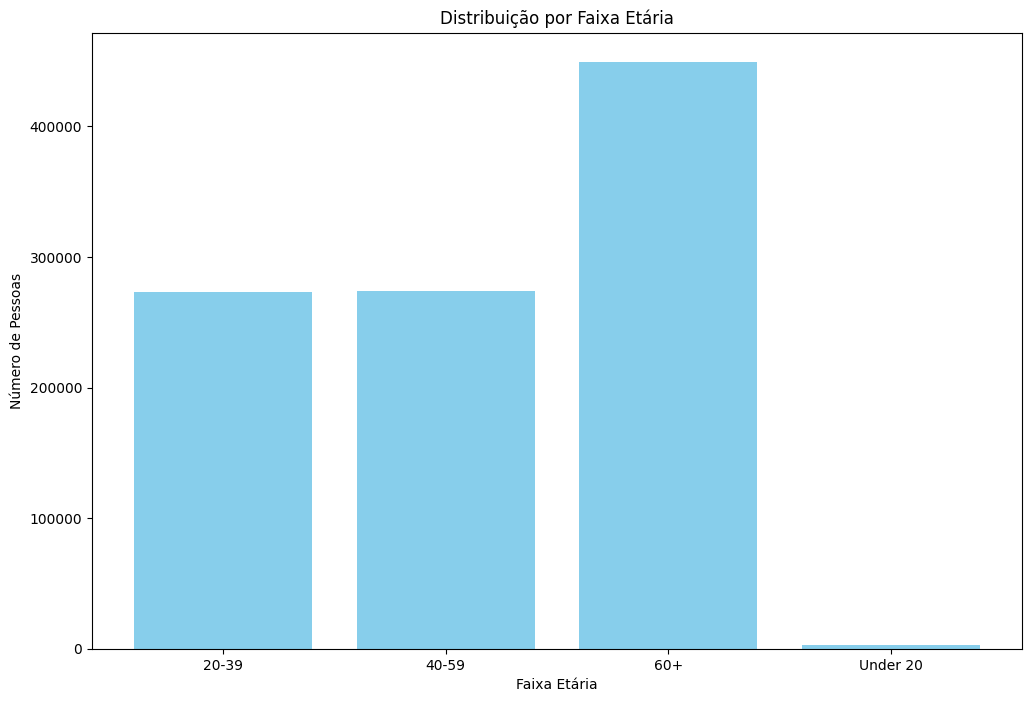

In [29]:
# Criando o grafico
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
plt.bar(age_counts['age_group'], age_counts['count'], color='skyblue')
plt.title('Distribuição por Faixa Etária')
plt.xlabel('Faixa Etária')
plt.ylabel('Número de Pessoas')
plt.show()

In [24]:
# Contagem de pessoas por País, ordenando por TOP 10
country_counts = df.groupBy('country_name').count().toPandas().sort_values('count', ascending=False).head(10)

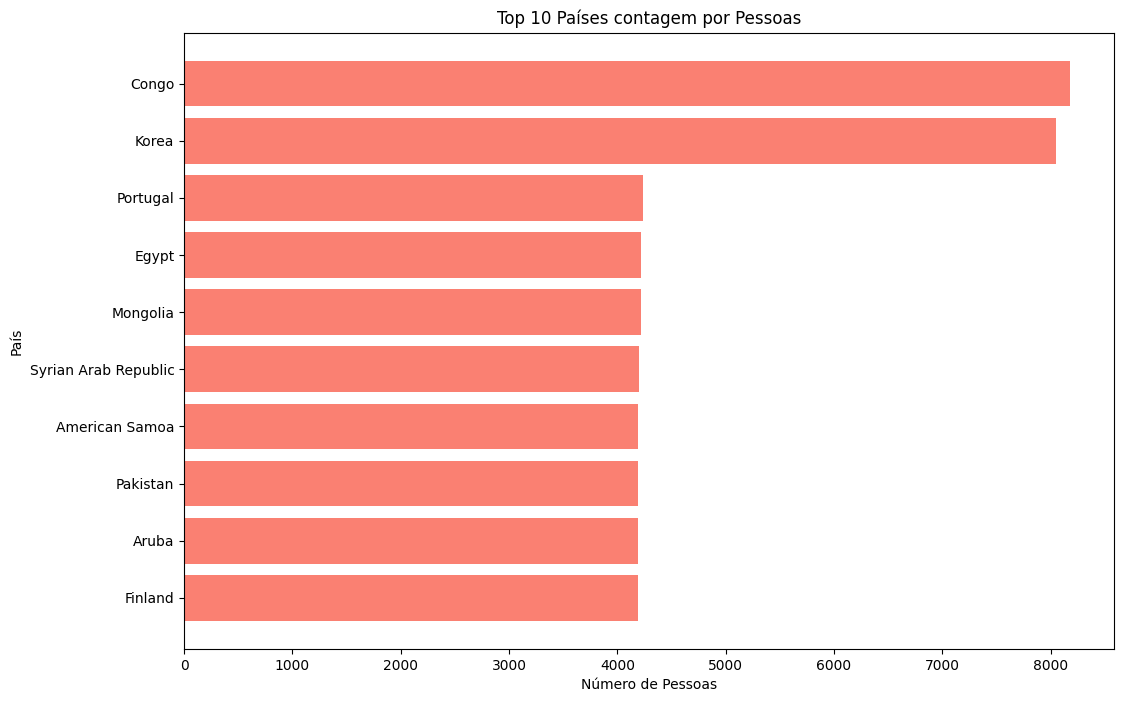

In [28]:
plt.figure(figsize=(12, 8))
plt.barh(country_counts['country_name'], country_counts['count'], color='salmon')
plt.title('Top 10 Países contagem por Pessoas')
plt.ylabel('País')
plt.xlabel('Número de Pessoas')
plt.gca().invert_yaxis()
plt.show()

In [30]:
# Contagem de pessoas por cidade
city_counts = df.groupBy('city_name').count().toPandas().sort_values('count', ascending=False).head(10)

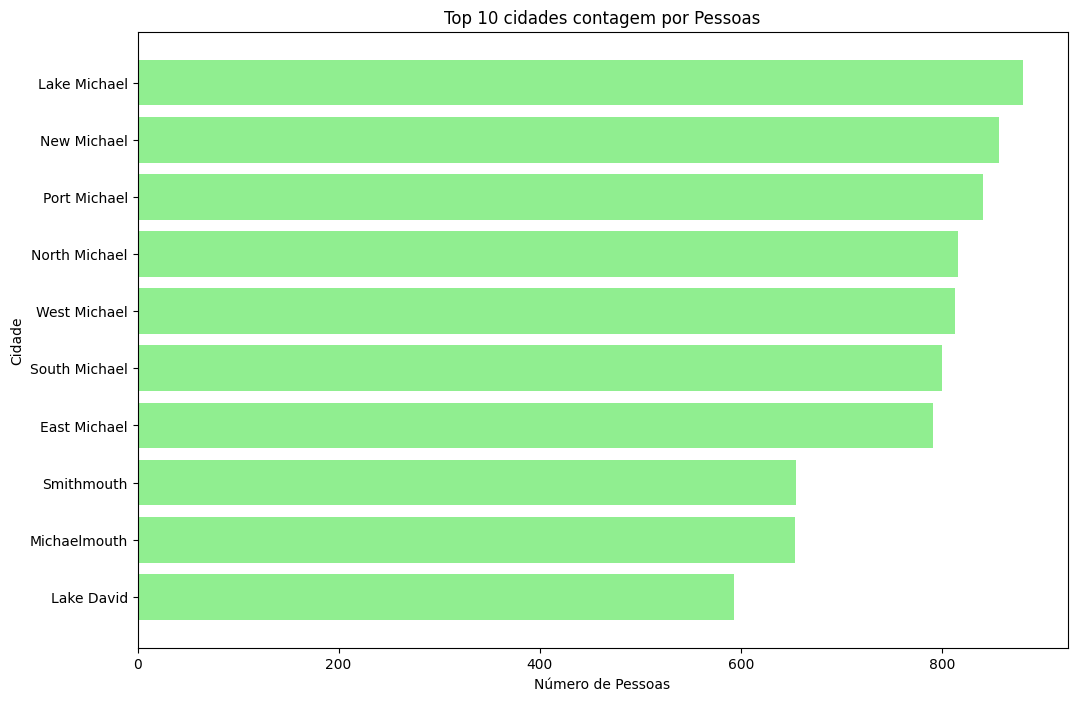

In [31]:
plt.figure(figsize=(12, 8))
plt.barh(city_counts['city_name'], city_counts['count'], color='lightgreen')
plt.title('Top 10 cidades contagem por Pessoas')
plt.ylabel('Cidade')
plt.xlabel('Número de Pessoas')
plt.gca().invert_yaxis()
plt.show()

In [32]:
# Ler o job_counts
jobs_df = spark.read.parquet('data-lake/trusted/jobs')

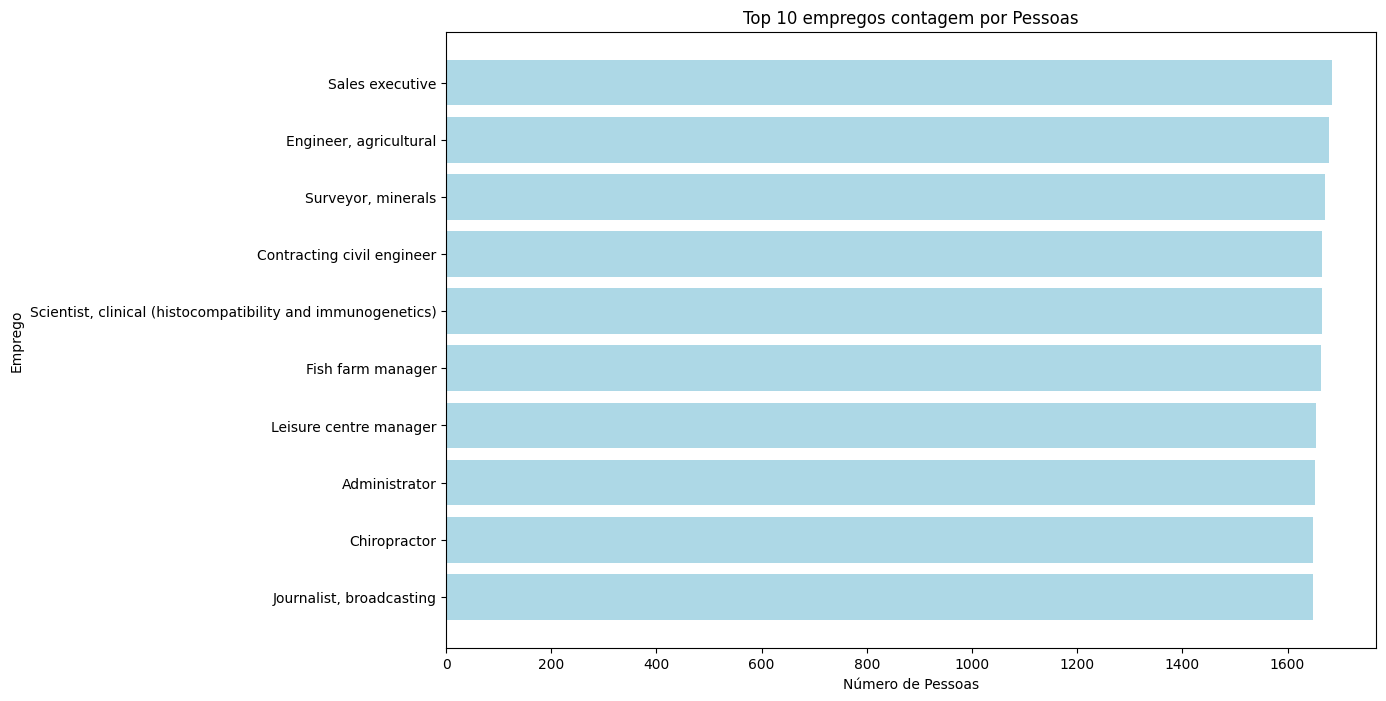

In [35]:
# grafico de empregos
job_counts = jobs_df.toPandas().sort_values('count', ascending=False).head(10)

plt.figure(figsize=(12, 8))
plt.barh(job_counts['job'], job_counts['count'], color='lightblue')
plt.title('Top 10 empregos contagem por Pessoas')
plt.ylabel('Emprego')
plt.xlabel('Número de Pessoas')
plt.gca().invert_yaxis()
plt.show()